# TCN Classifier

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
from torch.utils.data import DataLoader
import sys
import numpy as np
import random

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import Tcnn as tcn
from Tcnn import TemporalConvNet
import Baseline_classifiers as bc

In [19]:
data_path = '../data'

In [20]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Choose organism

In [21]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[1]
print(f"Using organism: {organism}")

Using organism: Drosophila.Melanogaster


### Set a Seed

In [22]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Test Dataset Preparation

In [23]:
# Data preparation
min_length = None
max_length = 500
one_hot = True

SPEEDS_ADDED = False
BATCH_SIZE = 32
pad_int = mlh.codons.index('___')

In [24]:
test_dataset = mlh.CodonDataset(organism, "test", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Länge test_dataset: 4023


### Load the newest model

In [25]:
tcn_model = mlh.load_model(f'tcn', organism, device=device)

Model loaded: 20240702011753_tcn_valid_acc_56.pt


### Predict the Codons for the test dataset

In [26]:
predicted, labels, accuracies = tcn.evaluate_model(tcn_model, device, test_loader, codon_names=False)

predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

#### Get codon names and associated amino acids

In [27]:
predicted_filtered, labels_filtered = mle.filter_padding(predicted, labels, filter_value=pad_int)

predicted_codon_names =  mle.codon_to_name(predicted_filtered)
labels_codon_names =  mle.codon_to_name(labels_filtered)

predicted_aa =  mle.translate_codons(predicted_codon_names)
labels_aa =  mle.translate_codons(labels_codon_names)

mle.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
mle.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  56 out of: 61
predicted following classes:  {'CTC', 'AAT', 'TAT', 'TCG', 'CCA', 'TCC', 'AAG', 'CCG', 'TGG', 'CGG', 'CAC', 'TCA', 'CCC', 'CAA', 'GGT', 'ATC', 'TGC', 'ACA', 'TTT', 'AGC', 'GTG', 'GAT', 'ACC', 'ATA', 'ACG', 'GCG', 'GGA', 'GAA', 'CAG', 'ATG', 'ACT', 'TTG', 'CAT', 'CGT', 'GAC', 'GGC', 'TCT', 'GTC', 'GAG', 'GCA', 'ATT', 'CGA', 'CGC', 'AAA', 'AGA', 'GTT', 'CCT', 'CTG', 'TTC', 'AAC', 'GCT', 'GCC', 'TGT', 'TAC', 'AGG', 'AGT'}
predicted different amino acids:  20 out of: 20


#### Accuracies

In [28]:
test_dataset = mlh.CodonDataset(organism=organism, split="test", padding_pos=None, one_hot_aa=False)
test_loader = DataLoader(test_dataset, batch_size=1)
print(f"Dataset loaded for {organism}")

classifier = tcn.Tcn_Classifier(tcn_model)
predictions = classifier.predict_codons(test_loader, codon_names=False, device=device)
predictions_acc = classifier.pad_and_convert_seq(predictions)

labels_acc = []
for seq, lab in test_dataset:
    lab = [int(c.item()) for c in lab]
    labels_acc.append(lab)

acc = classifier.calc_accuracy(labels_acc, predictions_acc, pad='')
print('Accuracy for:', organism, 'is:', acc)

Dataset loaded for Drosophila.Melanogaster


/home/mkuehn/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy for: Drosophila.Melanogaster is: 0.5559508017151695


## Result Visualization

### Index-based Segment Accuracy

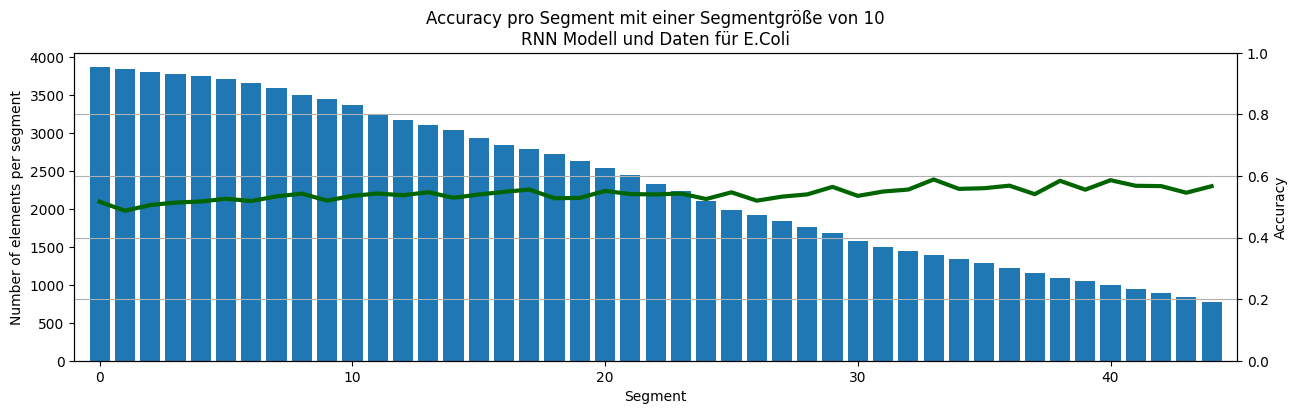

In [13]:
segment_size = 10
cut_data_at = 0.25

seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels_acc, predictions, segment_size=segment_size, cut_data_at=0.2)
mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nRNN Modell und Daten für {organism}")

### Confusion Matrix (Codons)

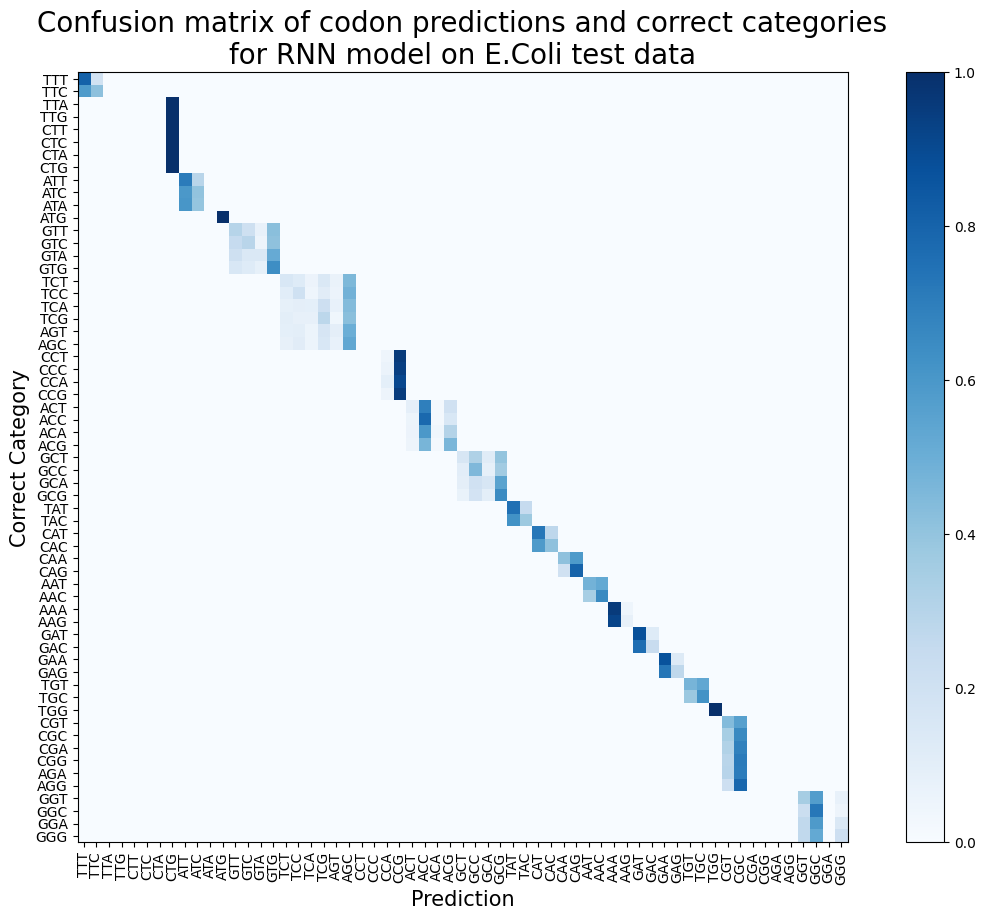

In [14]:
title = f'Confusion matrix of codon predictions and correct categories\nfor RNN model on {organism} test data'

codons = [c for c in mlh.codons if c != '___']

plt = mle.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Confusion Matrix (Amino acids)

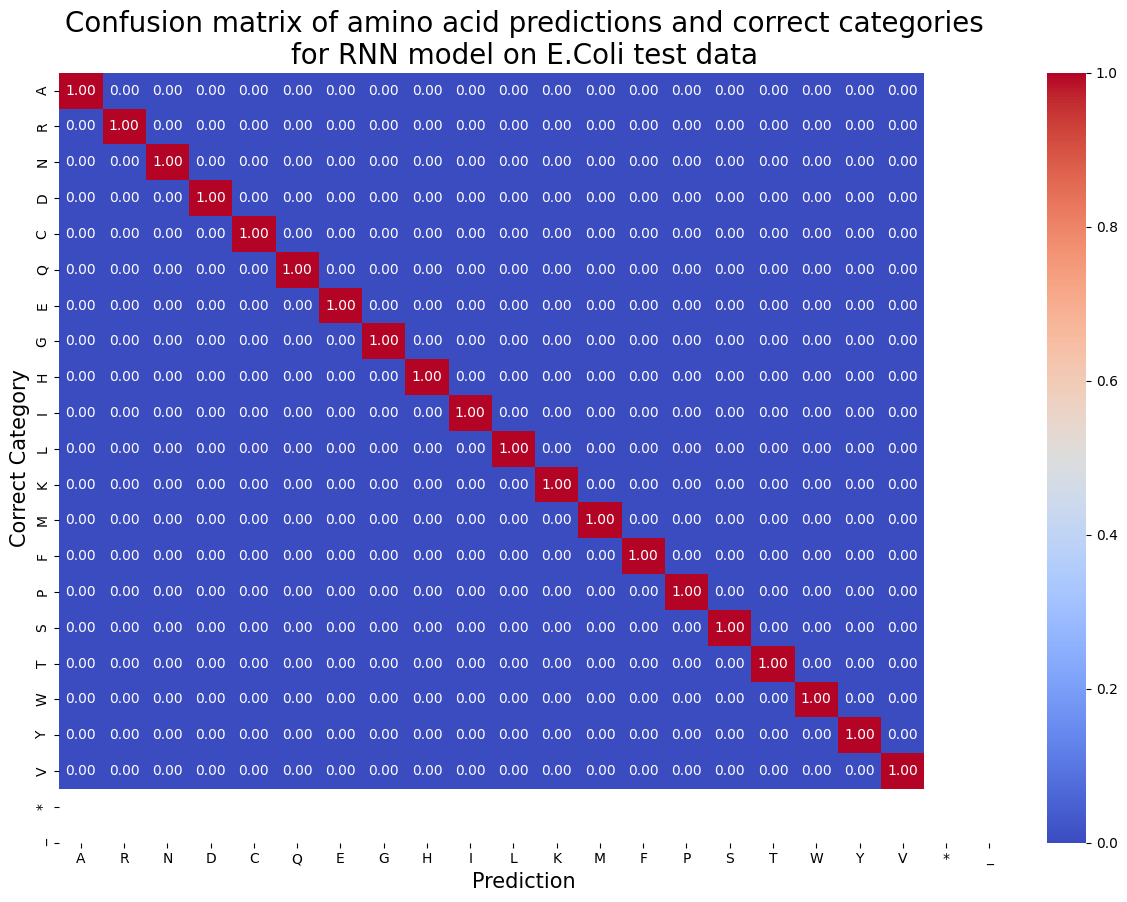

In [15]:
plt = mle.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        f'Confusion matrix of amino acid predictions and correct categories\nfor RNN model on {organism} test data')
plt.show()

### Accuracy per Codon

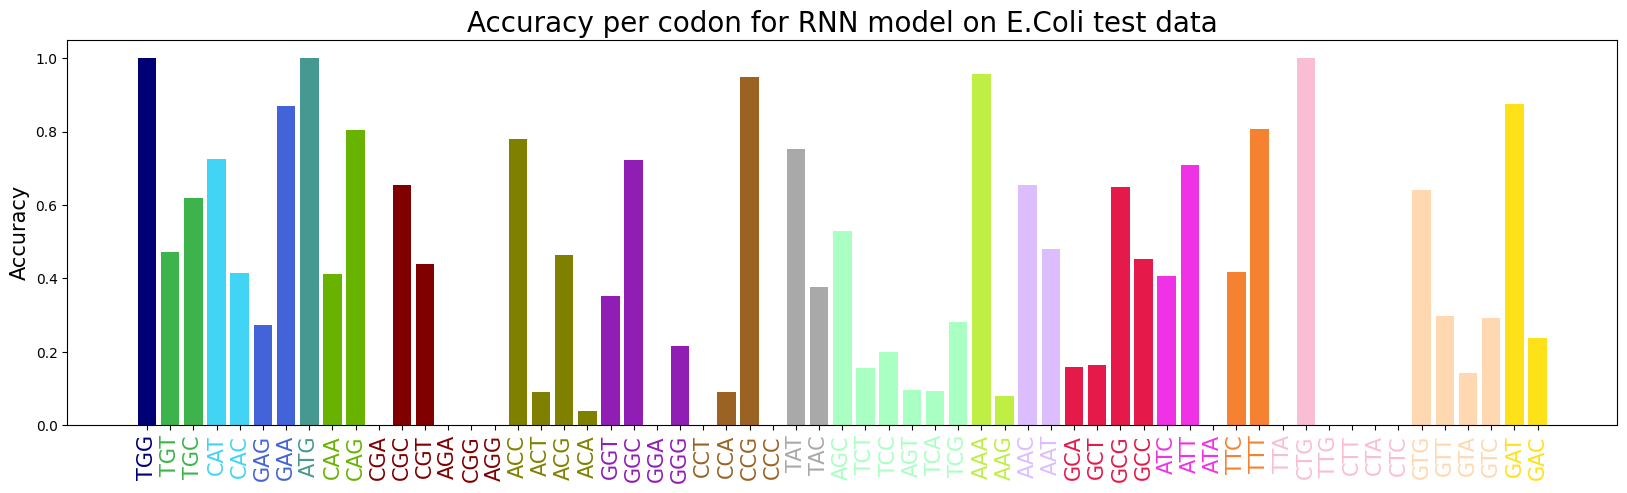

In [16]:
plt = mle.plot_codon_acc(labels, predicted, f'Accuracy per codon for RNN model on {organism} test data')

### Relative Prediction Frequency per Codon

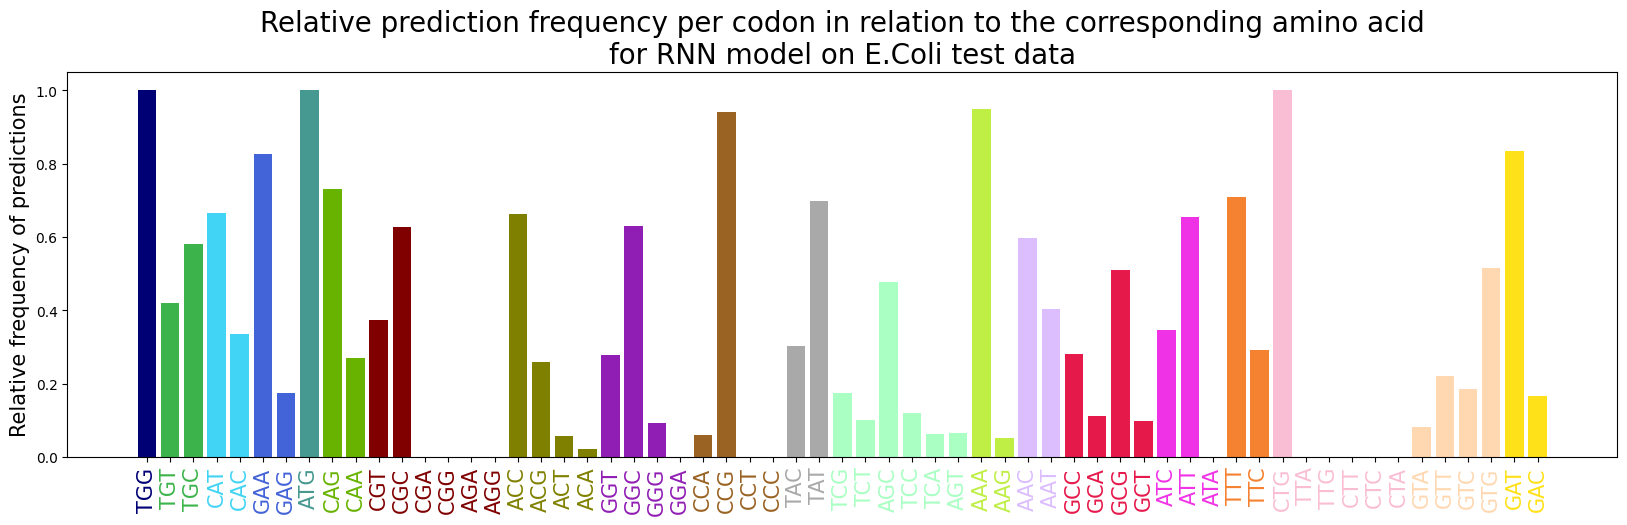

In [17]:
codon_counted_predicted = mle.codon_count(predicted)
plt = mle.plot_relative_codon_count(codon_counted_predicted,predicted, f'Relative prediction frequency per codon in relation to the corresponding amino acid\nfor RNN model on {organism} test data')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

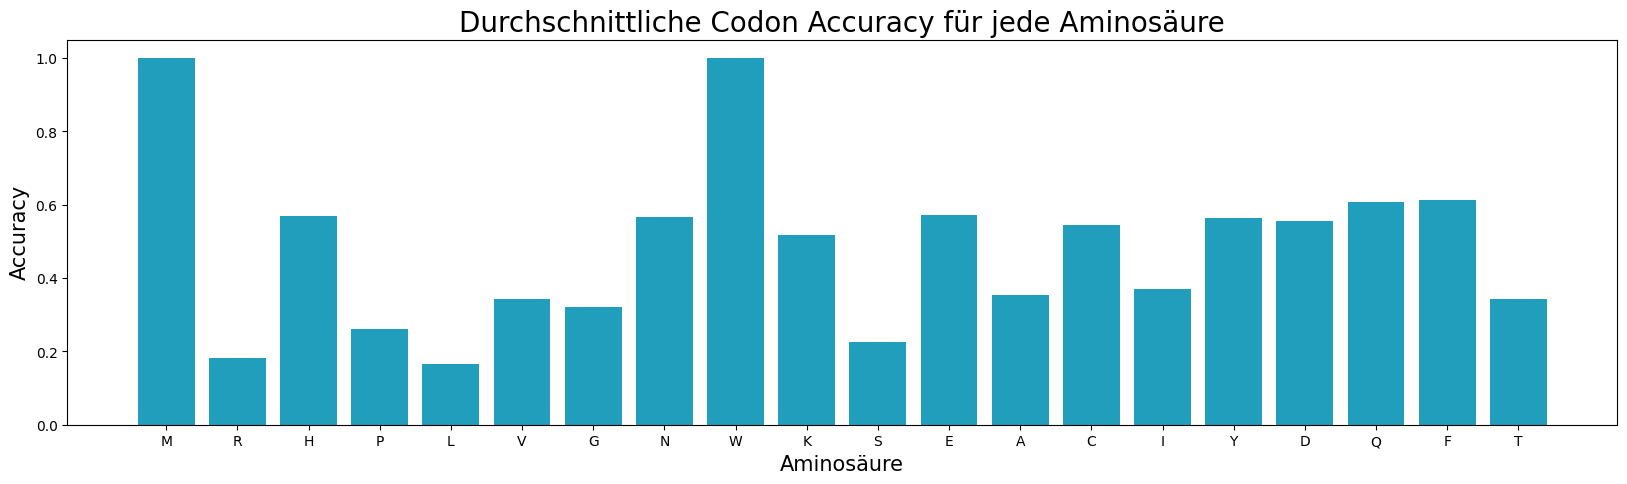

In [18]:
mle.plot_avg_aa_acc(labels, predicted).show()

### Test Shuffeld Data

In [19]:
test_shuffled_dataset = mlh.CodonDataset(organism, "test_shuffled", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_shuffled_dataset: {len(test_shuffled_dataset)}")

test_shuffled_loader = DataLoader(test_shuffled_dataset, batch_size=len(test_shuffled_dataset), shuffle=False)

Länge test_shuffled_dataset: 444


In [20]:
predicted_shuffled, labels_shuffled, accuracies_shuffled = tcn.evaluate_model(tcn_model, device, test_shuffled_loader, codon_names=False)

In [21]:
# Calculate Accuracy of amino 
avg_accuracy_shuffled = np.mean(accuracies_shuffled)
#accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print(f'For Organism {organism} Average shuffeld accuracy: {avg_accuracy_shuffled}')

For Organism E.Coli Average shuffeld accuracy: 0.484621940209091


### Comparison to MAX CUB

In [22]:
predicted_int = predicted.copy()
labels_int = labels.copy()

In [23]:
predicted = np.array([mlh.codons[p] for p in predicted_int])
labels = np.array([mlh.codons[int(p)] for p in labels_int])

pn_dict = mle.create_pn_dict(predicted, labels, organism)
print(pn_dict)

{'TTT': {'num': 2616, 'P_M==B': 0.8065749235473806, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0.19342507645259785}, 'TTC': {'num': 2051, 'P_M==B': 0, 'P_M!=B': 0.4178449536811242, 'N_M==B': 0.5821550463188536, 'N_M!=B': 0}, 'TTA': {'num': 1643, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 1.0000000000000275, 'N_M!=B': 0}, 'TTG': {'num': 1551, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 1.000000000000037, 'N_M!=B': 0}, 'CTT': {'num': 1222, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 1.0000000000000209, 'N_M!=B': 0}, 'CTC': {'num': 1204, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 1.0000000000000142, 'N_M!=B': 0}, 'CTA': {'num': 423, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 1.0000000000000013, 'N_M!=B': 0}, 'CTG': {'num': 6404, 'P_M==B': 0.9999999999998289, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0}, 'ATT': {'num': 3637, 'P_M==B': 0.7077261479241309, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0.2922738520758829}, 'ATC': {'num': 3008, 'P_M==B': 0, 'P_M!=B': 0.405585106382974, 'N_M==B': 0.5944148936170139, 'N_M!=B': 0}, 'ATA': {'num': 465, 'P_

In [24]:
cub_test_data = {}

for codon in pn_dict:
    aa = mlh.codon_to_amino_acid[codon]
    aa_codons = mlh.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum

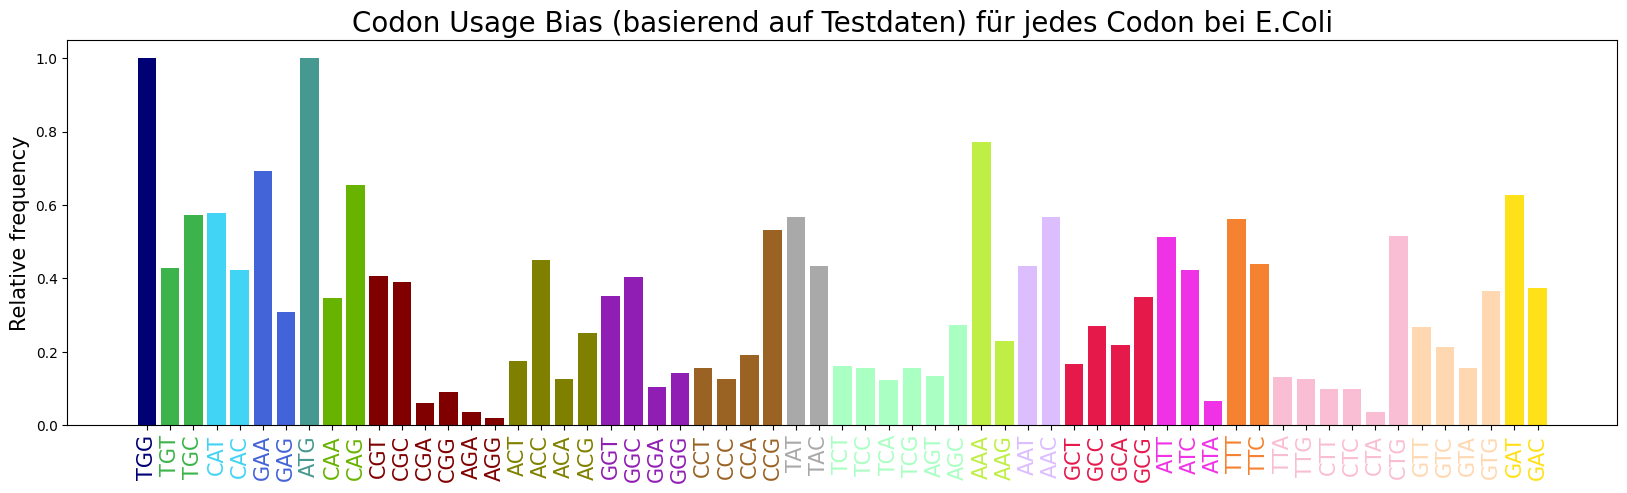

In [25]:
_, keys = mle.plot_cub(cub_test_data, f"Codon Usage Bias (basierend auf Testdaten) für jedes Codon bei {organism}")

In [26]:
pn_dict = { codon : pn_dict[codon] for codon in keys if codon in pn_dict}

<module 'matplotlib.pyplot' from '/Users/mx/Developer/Codons/.conda/lib/python3.12/site-packages/matplotlib/pyplot.py'>

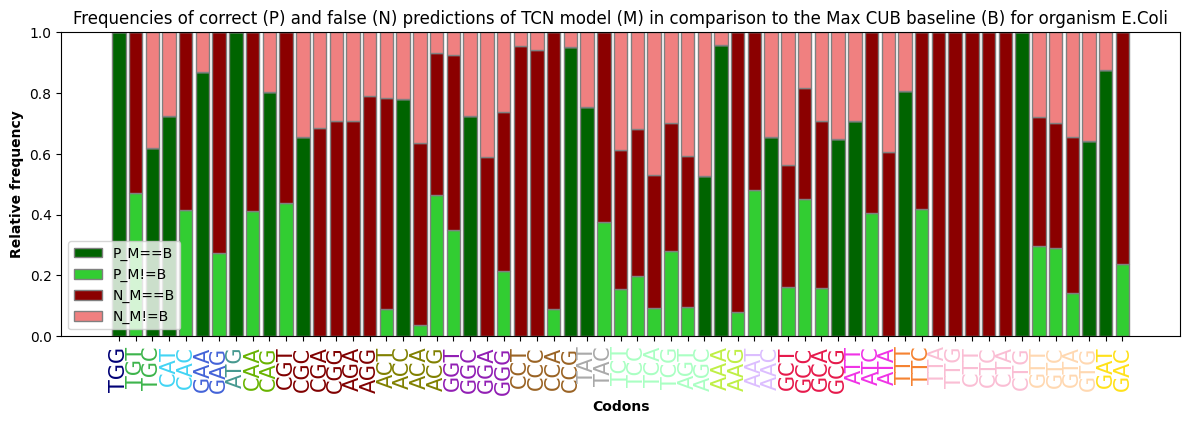

In [27]:
mle.plot_pn_dict(pn_dict, 'TCN', organism).show()